# Regression

- Predict the size of the effected area of a forest fire

Candidate: jianfei.zhang@live.ca

In [1]:
import sys
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import matplotlib as mpl

sys.path.insert(0, "../name-package")
import jzspine
plt.style.use('../name-package/jz-dark.mplstyle')
mpl.rcParams['figure.dpi']=300
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
def check_missing_values(d_train, d_test):
    fig, ax = plt.subplots(1, 2,  figsize=(30, 4))
    msno.matrix(d_train, ax=ax[0], sparkline=False)
    fig_miss = msno.matrix(d_test, ax=ax[1], sparkline=False)
    fig_miss.get_figure().savefig('miss.png', bbox_inches = 'tight')
    plt.show()
    
def impute_missing_values(d_train, d_test):
    d = d_train.append(d_test)
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    d[var_numerical] = imputer.fit_transform(d[var_numerical],1)
    # get training and test data back
    d_train, d_test = d.iloc[:d_train.shape[0]], d.iloc[d_train.shape[0]:]
    fig, ax = plt.subplots(1, 2,  figsize=(30, 4))
    msno.matrix(d_train, ax=ax[0], sparkline=False)
    msno.matrix(d_test, ax=ax[1], sparkline=False)
    plt.show()
    return d_train, d_test

def display_numerical(d_train):
    fig, axes = plt.subplots(2, 5,  figsize=(15, 5))
    plt.subplots_adjust(wspace=.2, hspace=.3)
    for i in range(10):
        x = d_train[var_numerical[i]].values
        row = int(np.floor(i/5)+1)
        col = int(i - (row-1)*5+1)
        axes[row-1,col-1].hist(x, bins=20, color=mpl.cm.Dark2.colors[1])
        axes[row-1,col-1].set_title('{}'.format(var_numerical[i]))
        fig.savefig('numerical.png', bbox_inches = 'tight')
    plt.show()

def display_categorical(d_train):
    fig, ax  = plt.subplots(1, 2, figsize=(10, 3))
    plt.subplots_adjust(wspace=0.2, hspace=.5)
    for i in range(2):
        x = d_train[var_categorical[i]].values
        ax[i].bar(list(Counter(x).keys()), list(Counter(x).values()), color=mpl.cm.Dark2.colors[2])
        ax[i].set_title('{}'.format(var_categorical[i]))
        fig.savefig('categorical.png', bbox_inches = 'tight')
    plt.show()
    
def display_var_response(d_train):
    plt.figure(figsize=(10,3))
    plt.bar(d_train.index.values,d_train[var_response].values, color=mpl.cm.Dark2.colors[3])
    plt.title('{}'.format(var_response))
    plt.savefig('response.png', bbox_inches = 'tight')
    plt.show()
    
# Find out the outliers and remove them all
def remove_outliers(d_train):
    outliers = d_train.index[d_train[var_response]>1000].tolist()
    if len(outliers)>0:
        display(d_train.loc[outliers])
        for i in outliers:
            d_train = d_train.drop([i])
    else: print('no outlier')
    return d_train

def create_dummies(d_train, d_test):
    d = d_train.append(d_test)
    dummies_month = pd.get_dummies(d.month)
    dummies_month = dummies_month.drop('oct',1)
    dummies_day = pd.get_dummies(d.day)
    dummies_day = dummies_day.drop('wed',1)
    d = pd.concat([dummies_month,dummies_day,d],1)
    var = var_numerical + list(dummies_month) + list(dummies_day)
    d_train, d_test = d.iloc[:d_train.shape[0]], d.iloc[d_train.shape[0]:]
    return d_train, d_test, var

def display_var_response_correlation(d_train, var):
    plt.figure(figsize=(6,4))
    matrix = np.triu(df_train[var].corr())
    sns.heatmap(df_train[var].corr(), xticklabels=df_train[var].columns, yticklabels=df_train[var].columns, mask=matrix, cmap="Greens")
    plt.title('Correlation')
    plt.savefig('correlation.png', bbox_inches = 'tight')
    plt.show()

In [3]:
# load training and test data
d_train, d_test = pd.read_csv("./Train/regression_train.csv").replace('NA', np.nan), pd.read_csv("./Test/regression_test.csv").replace('NA',np.nan)
var_categorical = ['month', 'day']
var_response = 'area'
var_numerical = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [15]:
d_train

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,8.0,6.0,aug,sat,92.2,81.8,480.8,11.9,20.1,34.0,4.5,0.0,58.30
1,4.0,3.0,may,fri,89.6,25.4,73.7,5.7,18.0,40.0,4.0,0.0,38.48
2,4.0,5.0,aug,mon,96.2,175.5,661.8,16.8,32.6,26.0,3.1,0.0,2.77
3,6.0,4.0,aug,thu,95.2,131.7,578.8,10.4,20.3,41.0,4.0,0.0,1.90
4,8.0,6.0,aug,mon,92.1,207.0,672.6,8.2,21.1,54.0,2.2,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2.0,5.0,aug,sun,94.9,130.3,587.1,17.7,33.1,25.0,4.0,0.0,26.43
410,2.0,2.0,aug,tue,92.1,152.6,658.2,13.9,23.7,24.0,3.1,0.0,0.00
411,3.0,4.0,sep,fri,93.3,141.2,713.9,13.9,18.6,49.0,3.6,0.0,35.88
412,2.0,4.0,aug,wed,95.2,217.7,690.0,18.0,30.8,19.0,4.5,0.0,0.00


In [14]:
d_test

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7.0,4.0,oct,tue,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.00
1,8.0,6.0,aug,mon,92.3,88.9,495.6,8.5,24.1,27.0,3.1,0.0,0.00
2,8.0,6.0,aug,mon,91.5,145.4,608.2,10.7,8.0,86.0,2.2,0.0,0.00
3,6.0,5.0,aug,fri,63.5,70.8,665.3,0.8,17.0,72.0,6.7,0.0,0.00
4,5.0,5.0,mar,sat,91.7,35.8,80.8,7.8,15.1,27.0,5.4,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1.0,3.0,aug,fri,95.9,158.0,633.6,11.3,27.5,29.0,4.5,0.0,43.32
99,3.0,4.0,aug,tue,96.1,181.1,671.2,14.3,32.3,27.0,2.2,0.0,14.68
100,7.0,5.0,aug,tue,96.1,181.1,671.2,14.3,27.3,63.0,4.9,6.4,10.82
101,1.0,2.0,aug,fri,91.0,166.9,752.6,7.1,25.9,41.0,3.6,0.0,0.00


## Check missing values 

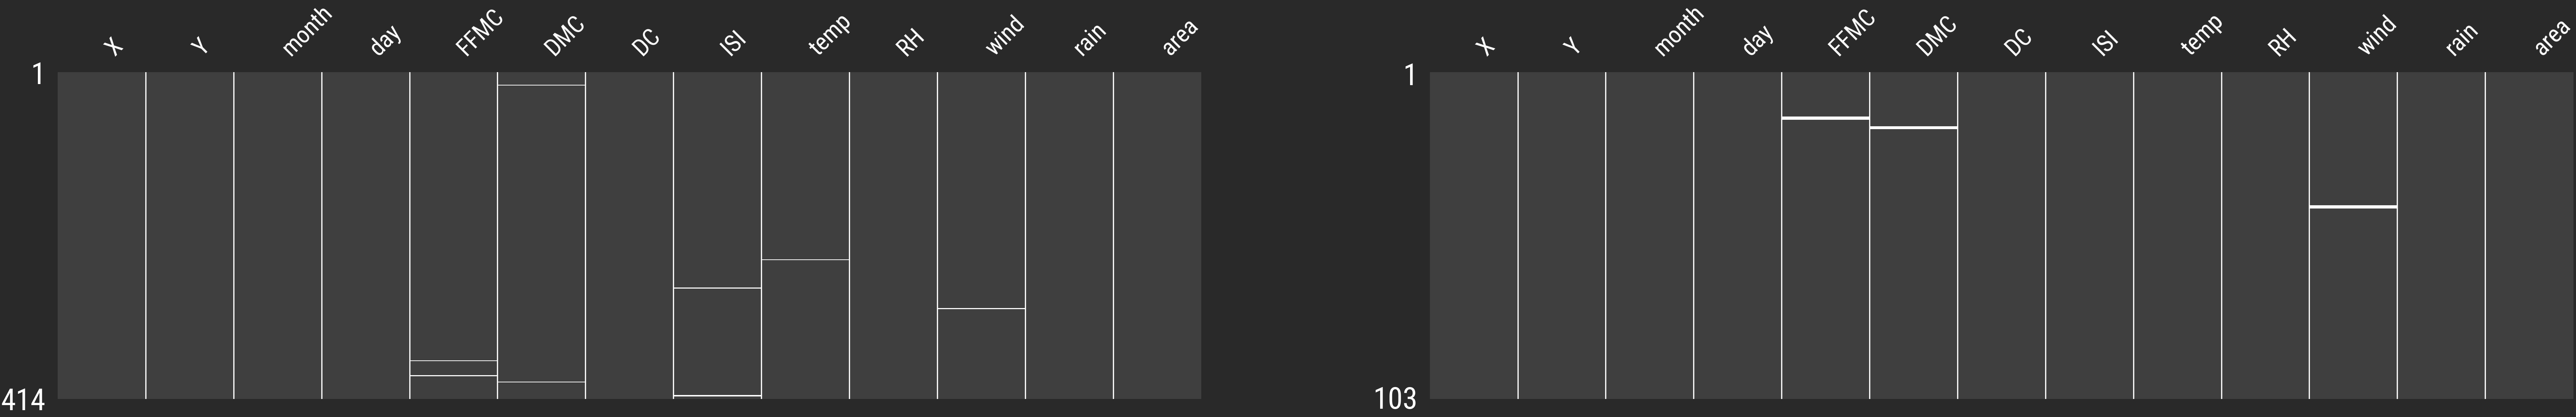

In [4]:
# There are missing values in both training and test data (only for numerical variables)
check_missing_values(d_train, d_test)

### Impute missing values

- nearest neighbors imputation method

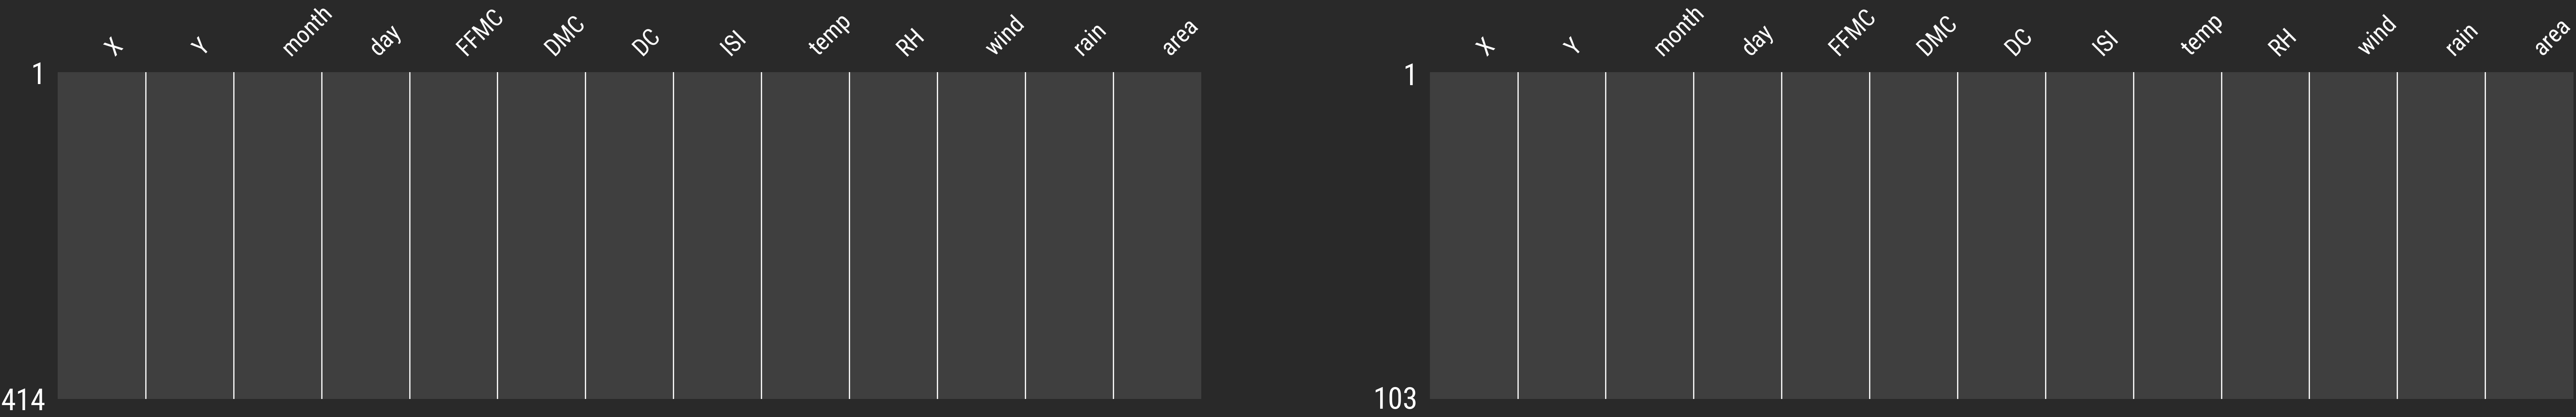

In [5]:
d_train, d_test = impute_missing_values(d_train, d_test)

## Visual Exploration

- The outcome 'area' has an outlier!!!

- The numerial variables have very few outliers and seem to follow normal distributions

- Three categorical variable (day) follows a uniform distribution, but the variable 'month' does not.

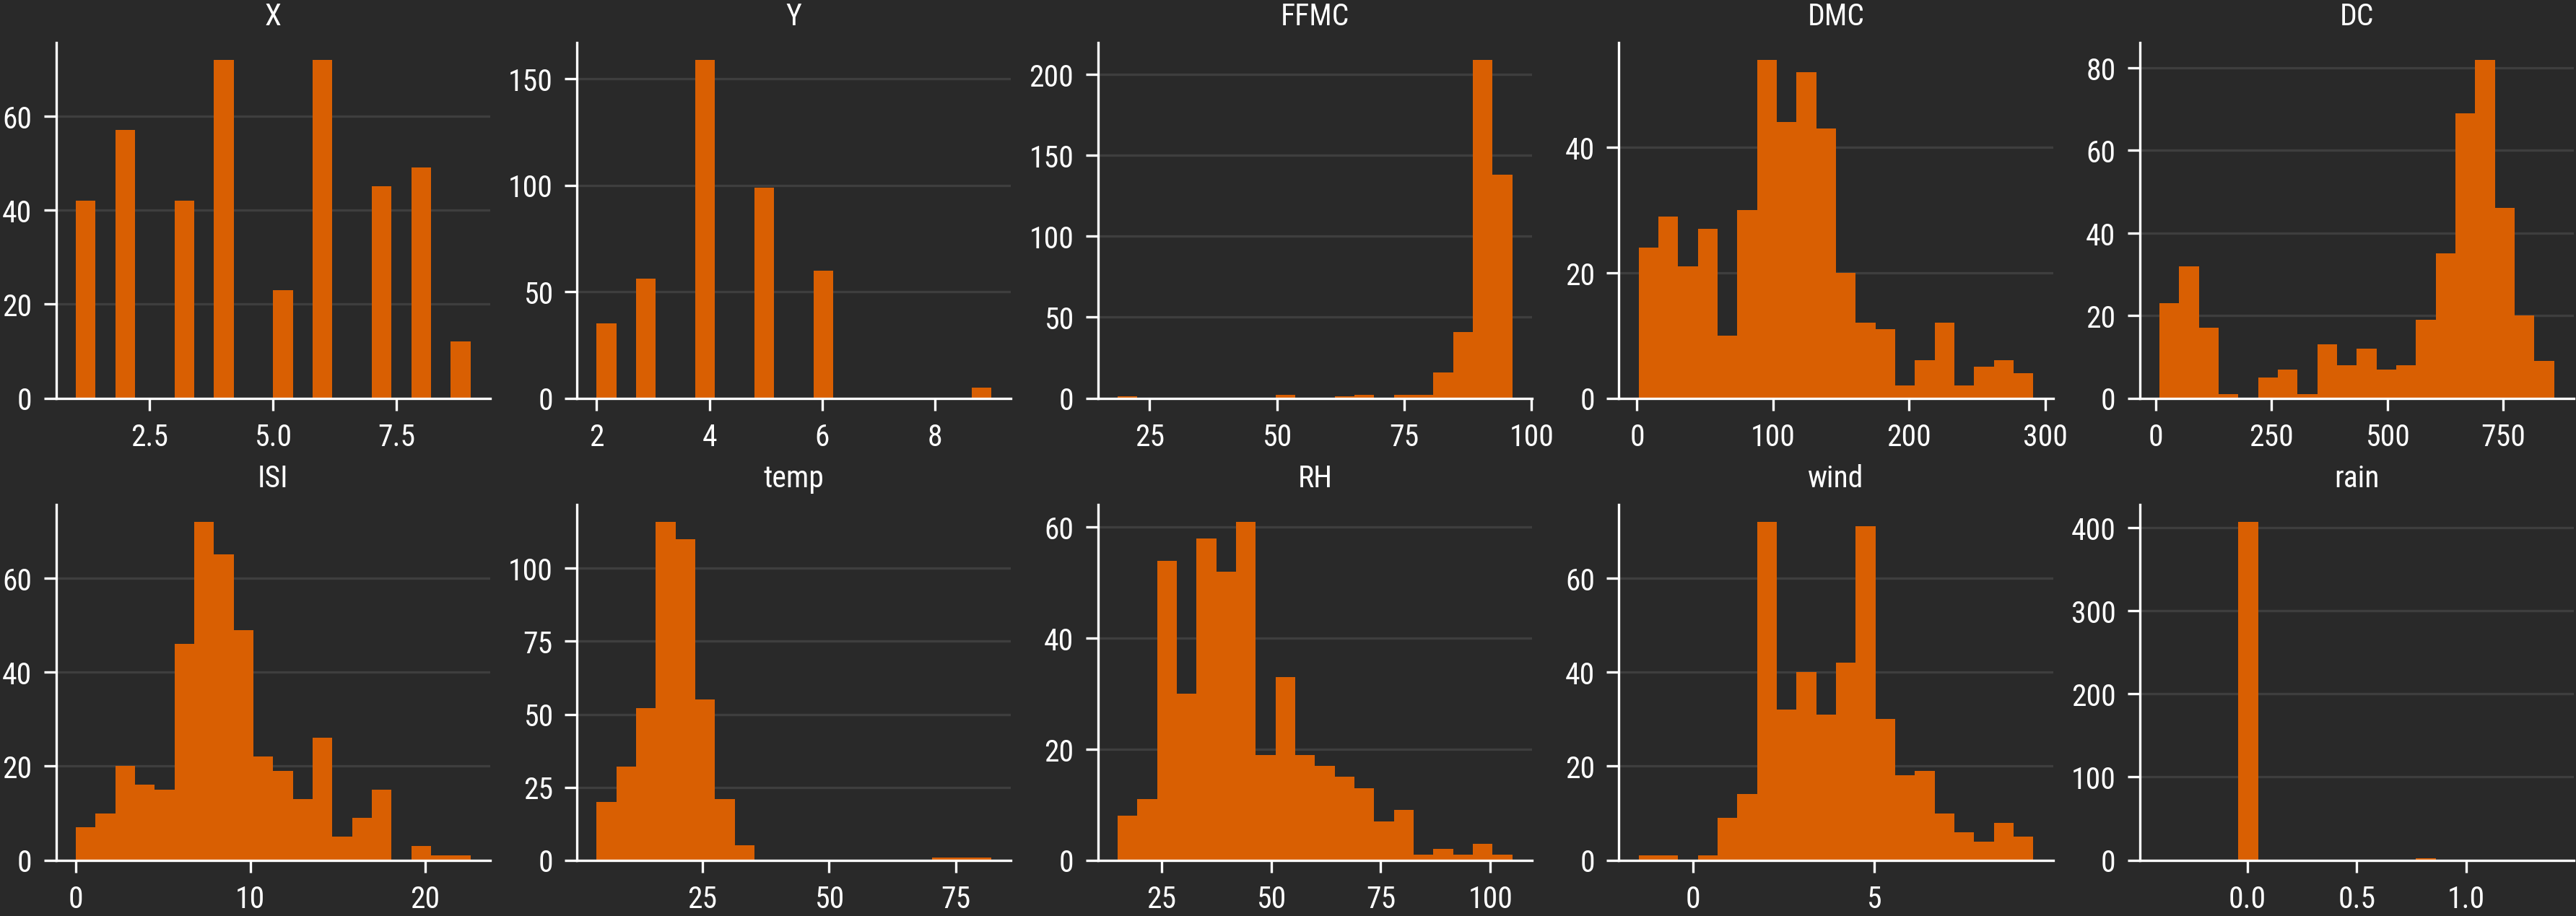

In [6]:
display_numerical(d_train)

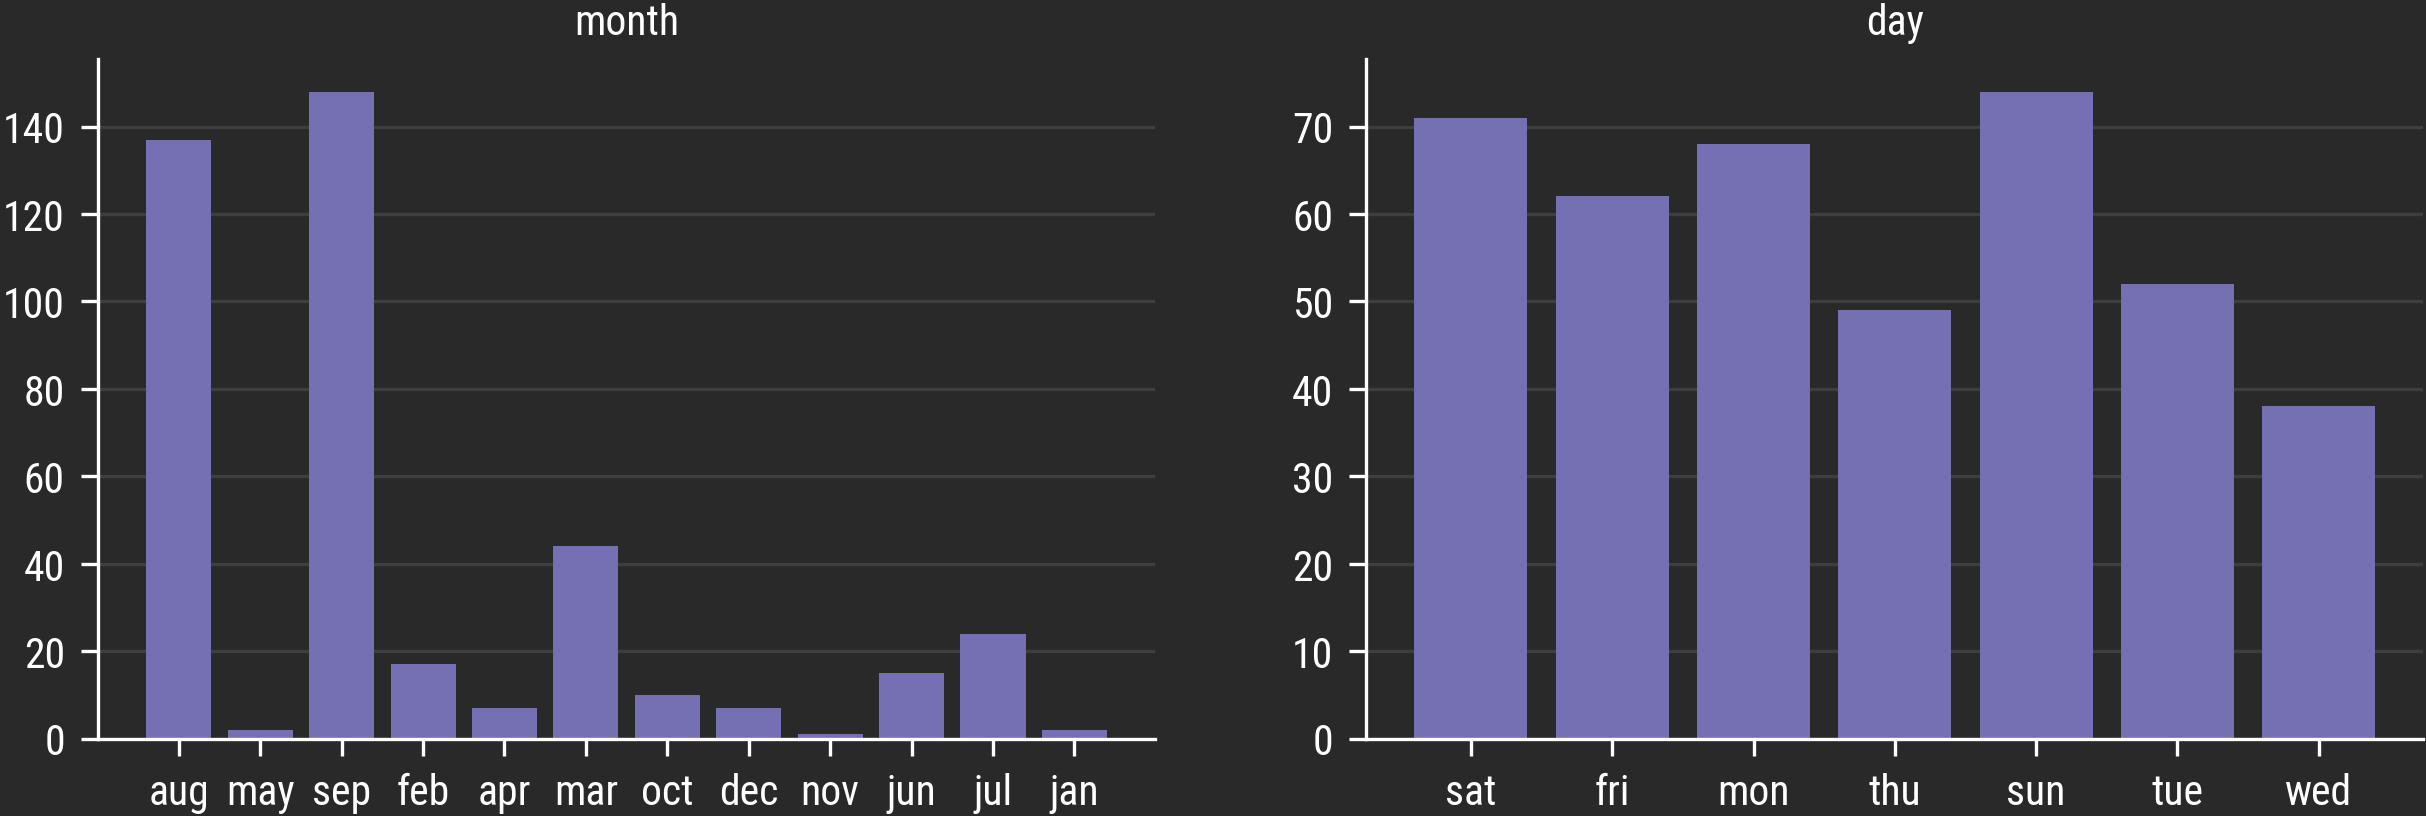

In [7]:
display_categorical(d_train)

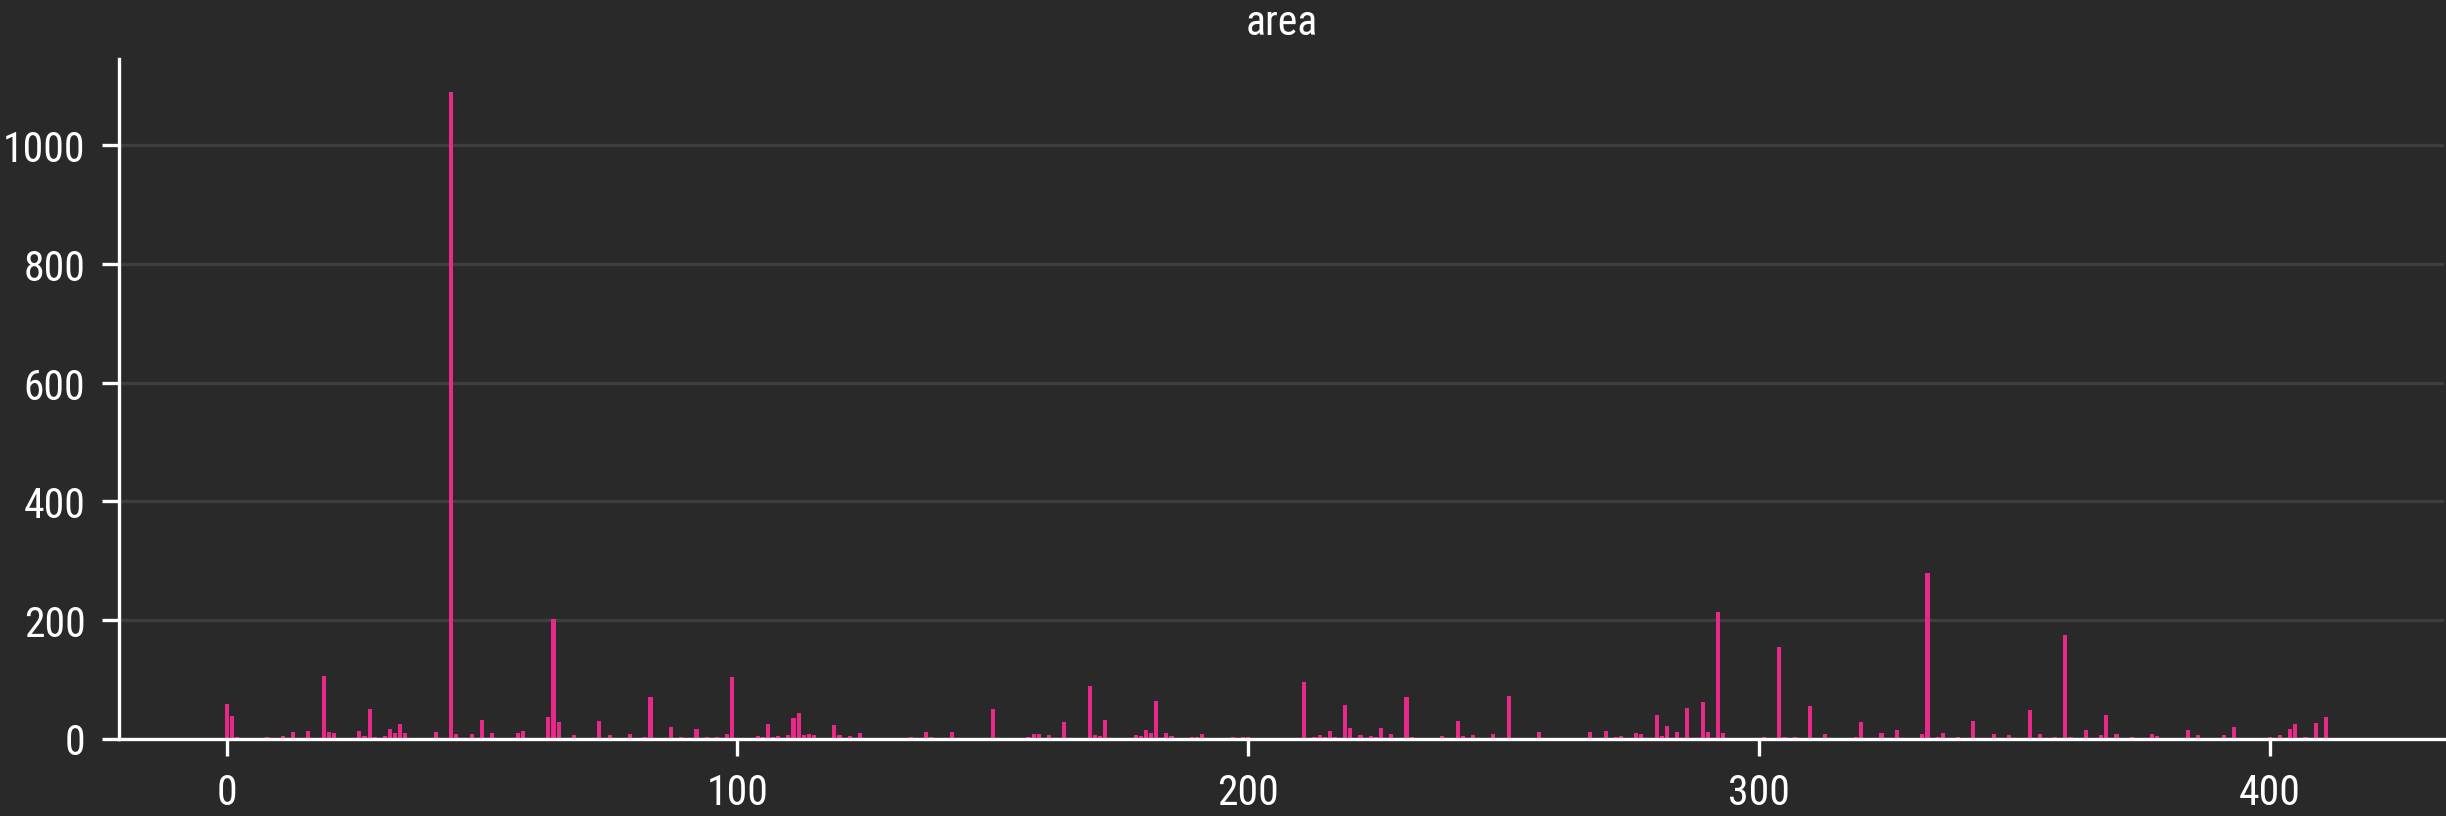

In [8]:
# an outlier

display_var_response(d_train)

In [9]:
# see the outlier below, and remove it
d_train = remove_outliers(d_train)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
44,6.0,5.0,sep,sat,92.5,121.1,674.4,8.6,25.1,27.0,4.0,0.0,1090.84


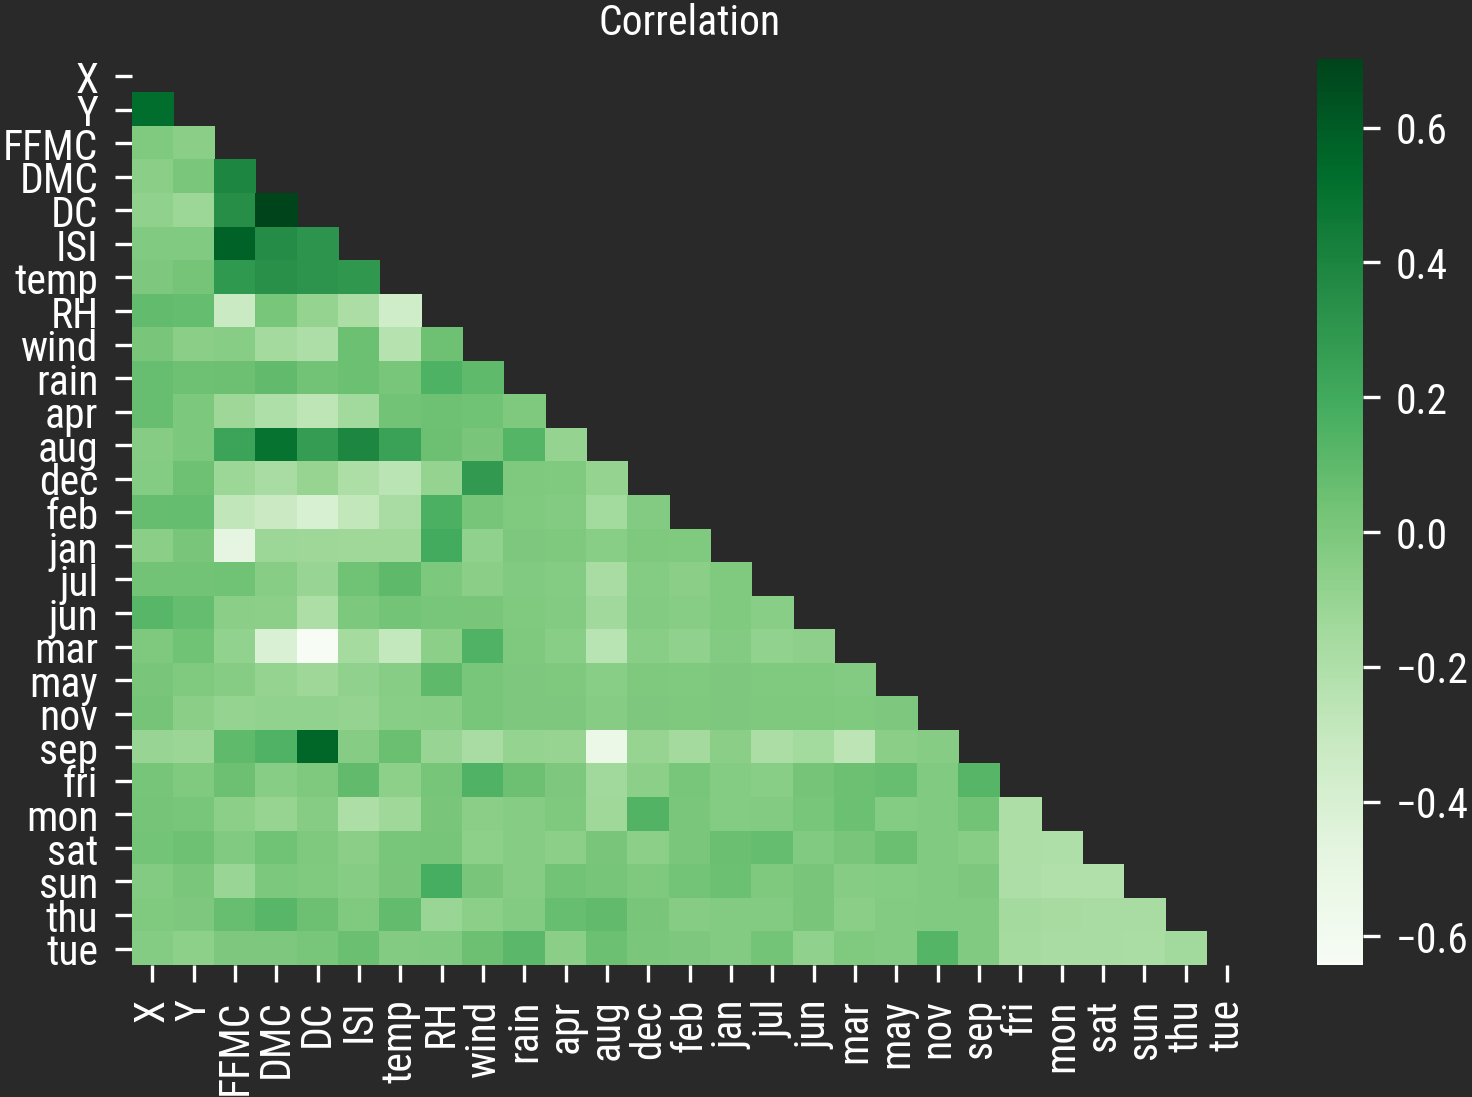

In [10]:
# The correlation between variables, no alert !
df_train, df_test, var = create_dummies(d_train, d_test)
display_var_response_correlation(d_train, var)

## Modeling and Prediction

- Five regression models: Lasso, Ridge, Elastic Net, Nearest Neighbor, and Decision Tree

- Evaluation metric: RMSE

In [11]:
# input x and output y
x_train, y_train = df_train[var], df_train[[var_response]]
x_test, y_test = df_test[var], df_test[[var_response]]

In [12]:
names = [
    "Lasso", 
    "Ridge", 
    "Elastic Net", 
    "Nearest Neighbor",
    'Decision Tree'
]

regressors = [
    Lasso(alpha=0.2),
    Ridge(alpha=1),
    ElasticNet(random_state=0),
    KNeighborsRegressor(n_neighbors=10),
    DecisionTreeRegressor(max_depth=2)
]


for name, clf in zip(names, regressors):
    clf.fit(x_train, y_train.values.ravel())
    y_pred = clf.predict(x_test.values)
    y_pred[y_pred<0]=0
    RMSE = mean_squared_error(y_test.values, y_pred, squared=False)
    print(name + ' RMSE is %.2f%%'% RMSE)

Lasso RMSE is 79.08%
Ridge RMSE is 79.25%
Elastic Net RMSE is 78.53%
Nearest Neighbor RMSE is 77.88%
Decision Tree RMSE is 78.77%
